# Install and Import


In [1]:
# Install necessary packages
!pip install geopandas shapely pyproj rtree

# Import libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, classification_report

# Load and Geocode Encampments

In [2]:
# Load encampment data
encampments = pd.read_csv('rehoused-encampments.csv')

# Create GeoDataFrame and project to UTM for meters
encampments_gdf = gpd.GeoDataFrame(
    encampments,
    geometry=gpd.points_from_xy(encampments['lon'], encampments['lat']),
    crs="EPSG:4326"
).to_crs(epsg=32617)  # UTM zone for accurate distance in meters

# Create Spatial Grid

In [3]:
# Create grid cells over encampment area
xmin, ymin, xmax, ymax = encampments_gdf.total_bounds
grid_size = 100  # 100 meter grid cells

cols = np.arange(xmin, xmax + grid_size, grid_size)
rows = np.arange(ymin, ymax + grid_size, grid_size)

polys = []
for x in cols:
    for y in rows:
        polys.append(box(x, y, x + grid_size, y + grid_size))

grid = gpd.GeoDataFrame({'geometry': polys}, crs=encampments_gdf.crs).reset_index().rename(columns={'index': 'cell_id'})

# Spatial Join and Create Labels

In [4]:
# Spatial join: which encampment in which cell
joined = gpd.sjoin(encampments_gdf, grid, how="left", predicate="within")
labels = joined.groupby(['cell_id', 'start_timestamp']).size().reset_index(name='count')
labels['presence'] = (labels['count'] > 0).astype(int)

# Create Full Cell x Month Matrix


In [5]:
# Make full cell x month grid
all_months = labels['start_timestamp'].unique()
all_cells = grid['cell_id'].unique()

full_index = pd.MultiIndex.from_product([all_cells, all_months], names=['cell_id', 'start_timestamp'])
full_df = pd.DataFrame(index=full_index).reset_index()
full_df['start_timestamp'] = pd.to_datetime(full_df['start_timestamp'], format='%b-%y')
labels['start_timestamp'] = pd.to_datetime(labels['start_timestamp'], format='%b-%y')

# Merge presence labels into full grid x month DataFrame
full_df = full_df.merge(labels[['cell_id', 'start_timestamp', 'presence']], on=['cell_id', 'start_timestamp'], how='left')
full_df['presence'] = full_df['presence'].fillna(0).astype(int)

# Extract Date and Geo Features

In [6]:
# Add month/year features
full_df['month'] = full_df['start_timestamp'].dt.month
full_df['year'] = full_df['start_timestamp'].dt.year

# Compute centroids for each grid cell (to add lat/lon)
grid['centroid'] = grid.geometry.centroid

# Reproject centroids to WGS84 (lat/lon) for output
grid_centroids = grid[['cell_id', 'centroid']].copy()
grid_centroids = grid_centroids.set_geometry('centroid').to_crs(epsg=4326)

# Extract lat/lon
grid_centroids['lat'] = grid_centroids.geometry.y
grid_centroids['lon'] = grid_centroids.geometry.x

full_df = full_df.merge(grid_centroids[['cell_id', 'lat', 'lon']], on='cell_id', how='left')
print(full_df['presence'].value_counts())

presence
0    2579620
1       1068
Name: count, dtype: int64


# Add Temporal Features

In [7]:
# ADD TEMPORAL LAG AND TREND FEATURES
full_df = full_df.sort_values(['cell_id', 'start_timestamp'])

# Previous month presence
full_df['lag1'] = full_df.groupby('cell_id')['presence'].shift(1)

# 2 months back
full_df['lag2'] = full_df.groupby('cell_id')['presence'].shift(2)

# Rolling average trend over 3 months
full_df['trend_3mo'] = (
    full_df.groupby('cell_id')['presence']
    .rolling(3, min_periods=1).mean()
    .reset_index(level=0, drop=True)
)

# Fill any NaNs that appear (e.g., for first month in a cell)
full_df[['lag1', 'lag2', 'trend_3mo']] = full_df[['lag1', 'lag2', 'trend_3mo']].fillna(0)

# Load Services and Compute Distances

~1min 40s to un

In [8]:
# Function to load service locations and project to grid CRS
def load_service(file):
  df = pd.read_csv(file)
  gdf = gpd.GeoDataFrame(df,
    geometry=gpd.points_from_xy(df['lon'], df['lat']),
    crs="EPSG:4326"
  ).to_crs(grid.crs)
  return gdf

# Load service points
libraries = load_service('rehoused-libraries.csv')
foodbanks = load_service('updated-foodbanks.csv')
wifi = load_service('rehoused-wifi.csv')
washrooms = load_service('rehoused-washrooms.csv')
medical = load_service('rehoused-medical-updated.csv')
stops = load_service('rehoused-stops.csv')

# Compute nearest distances from each grid cell centroid to services
def compute_nearest_distance(grid, service_gdf, feature_name):
  grid[feature_name] = grid.geometry.centroid.apply(
      lambda point: service_gdf.distance(point).min()
  )

compute_nearest_distance(grid, libraries, 'dist_library')
compute_nearest_distance(grid, foodbanks, 'dist_foodbank')
compute_nearest_distance(grid, wifi, 'dist_wifi')
compute_nearest_distance(grid, washrooms, 'dist_washroom')
compute_nearest_distance(grid, medical, 'dist_medical')
compute_nearest_distance(grid, stops, 'dist_stop')

# Merge distance features into full_df
full_df = full_df.merge(grid.drop(columns='geometry'), on='cell_id', how='left')

In [9]:
print(grid.columns)

Index(['cell_id', 'geometry', 'centroid', 'dist_library', 'dist_foodbank',
       'dist_wifi', 'dist_washroom', 'dist_medical', 'dist_stop'],
      dtype='object')


# Prepare Training Data

In [10]:
# Features for model — now with lag/trend!
feature_cols = [
    'dist_library', 'dist_foodbank', 'dist_wifi',
    'dist_washroom', 'dist_medical', 'dist_stop',
    'month', 'year', 'lag1', 'lag2', 'trend_3mo'
]

# use all available encampment data
last_month = full_df['start_timestamp'].max()
train_df = full_df.copy()

positive = train_df[train_df['presence'] == 1]
negative = train_df[train_df['presence'] == 0]

negative_downsampled = resample(
    negative,
    replace=False,
    n_samples=len(positive) * 10,
    random_state=42
)

balanced_train_df = pd.concat([positive, negative_downsampled]).sample(frac=1, random_state=42)

X_train = balanced_train_df[feature_cols]
y_train = balanced_train_df['presence']

# Train Random Forest Model

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    min_samples_leaf=10
)

clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, random_state=42)

# Generate and Predict Future Months

In [12]:
# create future 12 months
from pandas.tseries.offsets import MonthBegin

last_month = full_df['start_timestamp'].max()

future_months = pd.date_range(
    start=last_month + MonthBegin(1),
    periods=12,
    freq='MS'
)

future_index = pd.MultiIndex.from_product(
    [grid['cell_id'].unique(), future_months],
    names=['cell_id', 'start_timestamp']
)
future_df = pd.DataFrame(index=future_index).reset_index()

# concat with existing data
full_future_df = pd.concat([full_df, future_df], ignore_index=True)
full_future_df = full_future_df.sort_values(['cell_id', 'start_timestamp'])

# fill presence NA (for future rows)
full_future_df['presence'] = full_future_df['presence'].fillna(0).astype(int)

# recalc lag/trend
full_future_df['lag1'] = full_future_df.groupby('cell_id')['presence'].shift(1)
full_future_df['lag2'] = full_future_df.groupby('cell_id')['presence'].shift(2)
full_future_df['trend_3mo'] = (
    full_future_df.groupby('cell_id')['presence']
    .rolling(3, min_periods=1).mean()
    .reset_index(level=0, drop=True)
)
full_future_df[['lag1', 'lag2', 'trend_3mo']] = full_future_df[['lag1', 'lag2', 'trend_3mo']].fillna(0)

# add month/year
full_future_df['month'] = full_future_df['start_timestamp'].dt.month
full_future_df['year'] = full_future_df['start_timestamp'].dt.year



In [16]:
# add distance features (ensure they're in grid)
distance_cols = ['dist_library', 'dist_foodbank', 'dist_wifi', 'dist_washroom', 'dist_medical', 'dist_stop']
# 💡 check if distance features are already in the DataFrame
if not all(col in full_future_df.columns for col in distance_cols):
    full_future_df = full_future_df.merge(
        grid[['cell_id'] + distance_cols],
        on='cell_id',
        how='left'
    )

In [17]:
# map lat/lon (can be from full_df or grid_centroids!)
lat_lon_map = full_df.drop_duplicates(subset='cell_id').set_index('cell_id')[['lat', 'lon']]
full_future_df['lat'] = full_future_df['cell_id'].map(lat_lon_map['lat'])
full_future_df['lon'] = full_future_df['cell_id'].map(lat_lon_map['lon'])

In [18]:
# now PREDICT!
future_mask = full_future_df['start_timestamp'] > last_month
print("📋 checking feature_cols before prediction:")
print("➡️ feature_cols:", feature_cols)
print("✅ columns in full_future_df:", full_future_df.columns.tolist())
print("❌ missing from full_future_df:", [col for col in feature_cols if col not in full_future_df.columns])

X_forecast = full_future_df.loc[future_mask, feature_cols]

y_proba = clf.predict_proba(X_forecast)[:, 1]
full_future_df.loc[future_mask, 'pred_proba'] = y_proba
full_future_df.loc[future_mask, 'pred_class'] = (y_proba > 0.8).astype(int)

📋 checking feature_cols before prediction:
➡️ feature_cols: ['dist_library', 'dist_foodbank', 'dist_wifi', 'dist_washroom', 'dist_medical', 'dist_stop', 'month', 'year', 'lag1', 'lag2', 'trend_3mo']
✅ columns in full_future_df: ['cell_id', 'start_timestamp', 'presence', 'month', 'year', 'lat', 'lon', 'lag1', 'lag2', 'trend_3mo', 'centroid', 'dist_library_x', 'dist_foodbank_x', 'dist_wifi_x', 'dist_washroom_x', 'dist_medical_x', 'dist_stop_x', 'dist_library_y', 'dist_foodbank_y', 'dist_wifi_y', 'dist_washroom_y', 'dist_medical_y', 'dist_stop_y', 'dist_library', 'dist_foodbank', 'dist_wifi', 'dist_washroom', 'dist_medical', 'dist_stop']
❌ missing from full_future_df: []


# Save Data to future_encampment_predictions.csv and Download

In [24]:
# Save future predictions
cols_to_save = ['cell_id', 'start_timestamp', 'lat', 'lon', 'presence', 'pred_proba', 'pred_class'] + feature_cols
full_future_df[full_future_df['start_timestamp'] > last_month][cols_to_save].to_csv('encampment_forecast.csv', index=False)

# Download to local
from google.colab import files
files.download('encampment_forecast.csv')

print("✅ Done! File ready to download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Done! File ready to download.


# Tests

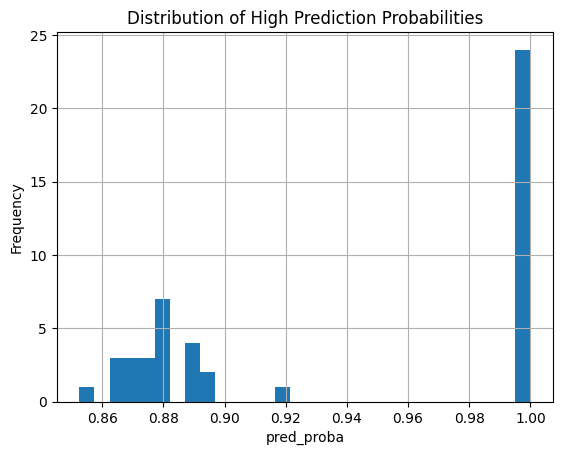

In [25]:
import matplotlib.pyplot as plt

high_preds = full_future_df.loc[full_future_df['start_timestamp'] > last_month, 'pred_proba']
high_preds[high_preds > 0.75].hist(bins=30)
plt.title("Distribution of High Prediction Probabilities")
plt.xlabel("pred_proba")
plt.ylabel("Frequency")
plt.show()
